# Climate & Asthma Outcomes Analysis
This notebook analyses the relationship between Wet Bulb Temperature (WBT) and Asthma-related Emergency Department (ED) visits in Singapore.

**Data Processing**

The dataset of asthma-related emergency department (ED) visits comprised 6435 individual records from 2015 to 2024, each representing a unique ED admission with an asthma diagnosis (ICD-10 code J459). To align the clinical data with environmental variables, the ED visit data were aggregated to the daily level, yielding the total number of asthma-related ED visits per calendar day.

Hourly wet bulb temperature (WBT) data were retrieved from the National Environment Agency’s public database and similarly aggregated to obtain the daily mean WBT for each date within the study period.

The two datasets were then merged using an inner join based on the date. Days without corresponding data in either dataset were excluded. This process resulted in a final analytical dataset of 2709 daily records, each containing the daily ED visit count and corresponding mean WBT. This aggregation enabled a time-series evaluation of the relationship between environmental thermal stress and asthma exacerbations at the population level.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.genmod.families import Poisson

# load data
merged_df = pd.read_csv('Merged_ED_WBT.csv', parse_dates=['date'])
merged_df.head()

,date,ed_visits,mean_wbt
0,2015-02-11,1,22.495833
1,2015-02-24,1,24.125000
2,2015-02-27,1,24.112500
3,2015-03-01,1,24.825000
4,2015-03-20,1,25.133333


## 1. Exploratory Analysis

c:\ProgramData\anaconda3\envs\mlaenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\mlaenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\mlaenv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\envs\mlaenv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

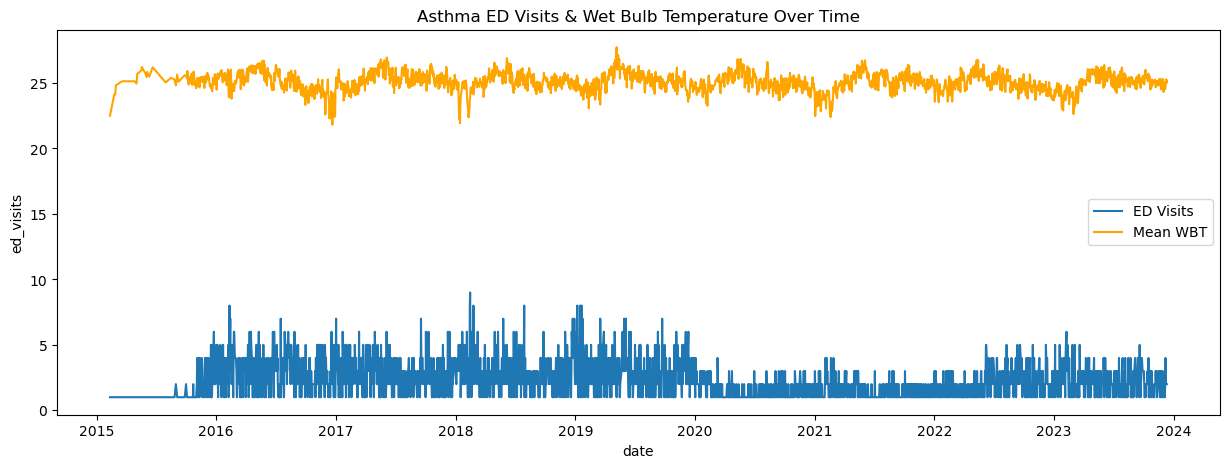

In [ ]:
# plot time series
plt.figure(figsize=(15,5))
sns.lineplot(data=merged_df, x='date', y='ed_visits', label='ED Visits')
sns.lineplot(data=merged_df, x='date', y='mean_wbt', label='Mean WBT', color='orange')
plt.title('Asthma ED Visits & Wet Bulb Temperature Over Time')
plt.legend()
plt.show()

## 2. Correlation Analysis

In [3]:
# Spearman & Pearson Correlation
spearman_corr = spearmanr(merged_df['mean_wbt'], merged_df['ed_visits'])
pearson_corr = pearsonr(merged_df['mean_wbt'], merged_df['ed_visits'])
print(f"Spearman correlation: {spearman_corr}")
print(f"Pearson correlation: {pearson_corr}")

Spearman correlation: SignificanceResult(statistic=0.00854463945096702, pvalue=0.6566560308343619)
Pearson correlation: PearsonRResult(statistic=-0.0008472180448813108, pvalue=0.964844056383313)


## 3. Lag Analysis (0-7 days)

In [ ]:
# lag analysis
for lag in range(0,8):
    merged_df[f'wbt_lag_{lag}'] = merged_df['mean_wbt'].shift(lag)

    corr = spearmanr(merged_df[f'wbt_lag_{lag}'].dropna(), merged_df['ed_visits'][lag:])
    print(f"Lag {lag} - Spearman correlation: {corr}")

Lag 0 - Spearman correlation: SignificanceResult(statistic=0.00854463945096702, pvalue=0.6566560308343619)
Lag 1 - Spearman correlation: SignificanceResult(statistic=0.0018846525209245408, pvalue=0.9219091086127448)
Lag 2 - Spearman correlation: SignificanceResult(statistic=-0.022602605215590533, pvalue=0.23975702803968485)
Lag 3 - Spearman correlation: SignificanceResult(statistic=-0.02114182050886684, pvalue=0.27159541893565287)
Lag 4 - Spearman correlation: SignificanceResult(statistic=-0.024963949413862836, pvalue=0.19429848951076487)
Lag 5 - Spearman correlation: SignificanceResult(statistic=-0.029032641950879387, pvalue=0.13121767238801715)
Lag 6 - Spearman correlation: SignificanceResult(statistic=-0.026321199418337476, pvalue=0.17129539645001235)
Lag 7 - Spearman correlation: SignificanceResult(statistic=-0.05103861327876782, pvalue=0.00796551543596111)


## 4. Poisson Regression

In [ ]:
# poisson Regression Model
model = glm('ed_visits ~ mean_wbt', data=merged_df, family=Poisson()).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              ed_visits   No. Observations:                 2709
Model:                            GLM   Df Residuals:                     2707
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4527.9
Date:                Mon, 31 Mar 2025   Deviance:                       1897.0
Time:                        23:27:31   Pearson chi2:                 2.02e+03
No. Iterations:                     4   Pseudo R-squ. (CS):          5.359e-07
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8820      0.441      1.999      0.0

## 5. Extreme WBT Event Analysis

In [ ]:
# identify extreme WBT events (above 95th percentile)
threshold = merged_df['mean_wbt'].quantile(0.95)
merged_df['extreme_wbt'] = merged_df['mean_wbt'] > threshold

# compare ED visits
extreme_visits = merged_df.loc[merged_df['extreme_wbt'], 'ed_visits']
normal_visits = merged_df.loc[~merged_df['extreme_wbt'], 'ed_visits']

print(f"Mean ED visits on extreme WBT days: {extreme_visits.mean()}")
print(f"Mean ED visits on normal days: {normal_visits.mean()}")

Mean ED visits on extreme WBT days: 2.3925925925925924
Mean ED visits on normal days: 2.3745143745143746


Correlation analysis showed no significant relationship between daily mean WBT and ED visits (Spearman r = 0.0085, p = 0.657).  
Time-lag analysis (lag 0–7 days) revealed no significant delayed effect, except for a small positive correlation at lag 7 days (Spearman r = 0.051, p = 0.008).  
Poisson regression analysis confirmed no significant association between WBT and ED visits (β = -0.0007, p = 0.970).  
Extreme event analysis comparing days with WBT ≥ 27.9°C (95th percentile) showed only a marginal and negligible increase in ED visits (2.39 vs 2.37 visits/day).

**Methods Section – Data Processing Paragraph**

To evaluate environmental effects on asthma exacerbations, two primary datasets were used: (1) patient-level ED admissions for asthma (ICD-10: J459) from the SingHealth system between 2015 and 2024, and (2) hourly wet bulb temperature (WBT) data from the National Environment Agency. The ED dataset contained 6435 individual admissions, each with timestamped visit dates.

To align with environmental data, the asthma ED dataset was aggregated to daily counts, yielding one record per day. The WBT dataset was also aggregated to daily mean values. These two time series were then merged by date, resulting in a final analytical dataset containing 2709 daily records with both WBT and asthma ED visit data. Days with missing WBT or without asthma admissions were excluded through inner join merging. This unified dataset formed the basis for time-series, correlation, lagged, and regression analyses.

**Discussion Section – Interpretation of WBT Findings**

Although wet bulb temperature (WBT) integrates both heat and humidity into a physiologically meaningful metric, it did not emerge as a significant predictor of asthma-related ED visits in this study. This contrasts with previous findings from temperate regions, where WBT has shown stronger associations with respiratory distress.

In a tropical setting like Singapore, high humidity is a near-constant baseline, and daily temperature fluctuations are comparatively narrow. As such, WBT may not vary sufficiently to trigger acute respiratory responses unless extreme events occur. Additionally, other factors—such as air pollution spikes (e.g., PSI) or monsoonal transitions—may play a more dominant role in asthma exacerbations. The non-significant results here highlight the need to explore compound climate-health interactions beyond single-variable thresholds.